In [25]:
!pip install datasets
!pip install wandb

In [26]:
import torch
torch.cuda.manual_seed_all(423)

In [27]:
MAX_LEN = 256
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUMBER_WORKERS = 2
EPOCHS = 5

In [28]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [29]:
from transformers import DistilBertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased"

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    # Each batch item is a dict: {'input_ids': ..., 'attention_mask': ..., 'label': ...}
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    # Pad to max length *within this batch*
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "input_ids": padded_input_ids,
        "attention_mask": padded_attention_masks,
        "labels": labels
    }


train_loader = DataLoader(tokenized["train"], batch_size= BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUMBER_WORKERS)
test_loader = DataLoader(tokenized["test"], batch_size = BATCH_SIZE, collate_fn=collate_fn, num_workers = NUMBER_WORKERS)

## C1

In [32]:
import wandb

wandb.init(project="hpml-hw2-llm", name=f"bs{BATCH_SIZE}_lr{LEARNING_RATE}", group = "Warm Up Experiment")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": MAX_LEN,
    "batch_size": BATCH_SIZE,
    "lr": LEARNING_RATE,
    "optimizer": "AdamW",
    "num_workers": NUMBER_WORKERS,
    "epochs": EPOCHS,
    "compile_mode": False
})

In [33]:
from tqdm import tqdm
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  for batch in tqdm(train_loader):
      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
           "train/acc": avg_accuracy,
           "test/acc": accuracy})
  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")


100%|██████████| 782/782 [01:54<00:00,  6.82it/s]


Epoch 1/5, Loss: 0.3006, Train Accuracy: 0.8747, Test Accuracy: 0.9017


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch 2/5, Loss: 0.1692, Train Accuracy: 0.9374, Test Accuracy: 0.8870


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch 3/5, Loss: 0.0885, Train Accuracy: 0.9704, Test Accuracy: 0.8797


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch 4/5, Loss: 0.0505, Train Accuracy: 0.9836, Test Accuracy: 0.8770


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch 5/5, Loss: 0.0382, Train Accuracy: 0.9881, Test Accuracy: 0.8744


In [34]:
wandb.finish()

test/acc,█▄▂▂▁
train/acc,▁▅▇██
test/acc,0.87444
train/acc,0.98808


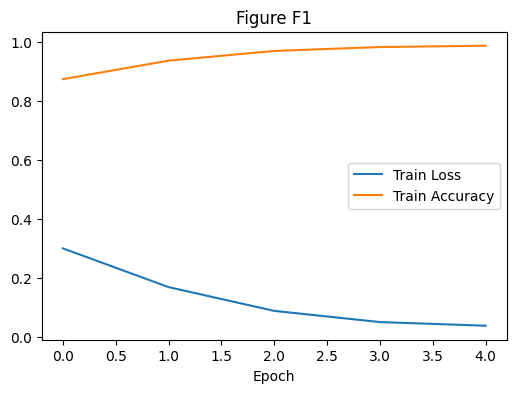

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Value')
plt.title('Figure F1')
plt.legend()
plt.show()

### Table T1

| Epoch | Train Loss | Train Acc | Test Acc |
|-------|------------|-----------|----------|
|1|0.0317|0.9902|0.8764|
|2|0.0246|0.9920|0.8895|
|3|0.0211|0.9932|0.8765|
|4|0.0178|0.9940|0.8791|
|5|0.0173|0.9947|0.8740|


# C2

In [36]:
wandb.init(project="hpml-hw2-llm", name=f"bs{BATCH_SIZE}_lr{LEARNING_RATE}", group = "Baseline Timing")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": MAX_LEN,
    "batch_size": BATCH_SIZE,
    "lr": LEARNING_RATE,
    "optimizer": "AdamW",
    "num_workers": NUMBER_WORKERS,
    "epochs": EPOCHS,
    "compile_mode": False
})

In [37]:
import time

In [38]:
train_loader = DataLoader(tokenized["train"], batch_size= BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUMBER_WORKERS)
test_loader = DataLoader(tokenized["test"], batch_size = BATCH_SIZE, collate_fn=collate_fn, num_workers = NUMBER_WORKERS)

In [40]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

train_loss = []
train_accuracy = []
test_accuracy = []
data_loading_time_arr = []
compute_time_arr = []
epoch_time_arr = []

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  data_loading_time = 0
  training_compute_time = 0
  total_epoch_time = 0
  start_data_loading = time.time()
  start_epoch_time = time.time()
  for batch in train_loader:
      torch.cuda.synchronize()
      end = time.time()
      data_loading_time +=  end - start_data_loading

      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      start_compute = time.time()
      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      torch.cuda.synchronize()
      end = time.time()
      training_compute_time += end - start_compute

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

      start_data_loading = time.time()

  end = time.time()
  total_epoch_time = end - start_epoch_time

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
            "train/acc": avg_accuracy,
            "test/acc": accuracy,
             "data-loading time": data_loading_time,
             "compute time": training_compute_time,
             "total epoch time": total_epoch_time})

  data_loading_time_arr.append(data_loading_time)
  compute_time_arr.append(training_compute_time)
  epoch_time_arr.append(total_epoch_time)
  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
          compute time: {training_compute_time} total epoch time: {total_epoch_time}")


Epoch 1/5, Loss: 0.0333, Train Accuracy: 0.9898, Test Accuracy: 0.8475, data_loading time: 2.4466664791107178           compute time: 109.78202104568481 total epoch time: 113.29317784309387
Epoch 2/5, Loss: 0.0228, Train Accuracy: 0.9927, Test Accuracy: 0.8472, data_loading time: 2.4001364707946777           compute time: 109.73737668991089 total epoch time: 113.1807632446289
Epoch 3/5, Loss: 0.0226, Train Accuracy: 0.9930, Test Accuracy: 0.8164, data_loading time: 2.3973660469055176           compute time: 109.73684787750244 total epoch time: 113.17370367050171
Epoch 4/5, Loss: 0.0214, Train Accuracy: 0.9931, Test Accuracy: 0.8360, data_loading time: 2.4157588481903076           compute time: 109.749671459198 total epoch time: 113.21418714523315
Epoch 5/5, Loss: 0.0188, Train Accuracy: 0.9948, Test Accuracy: 0.8305, data_loading time: 2.3909530639648438           compute time: 109.75265192985535 total epoch time: 113.18562865257263


In [ ]:
wandb.finish()

# C3

In [42]:
avg_data_loading_time_arr = []
avg_epoch_time_arr = []

for NUMBER_WORKERS in [0,2,4,8]:
  wandb.init(project="hpml-hw2-llm", name=f"bs{BATCH_SIZE}_lr{LEARNING_RATE}", group = "DataLoader Performance")

  wandb.config.update({
      "model_name": "distilbert-base-uncased",
      "max_len": MAX_LEN,
      "batch_size": BATCH_SIZE,
      "lr": LEARNING_RATE,
      "optimizer": "AdamW",
      "num_workers": NUMBER_WORKERS,
      "epochs": EPOCHS,
      "compile_mode": False
  })

  train_loader = DataLoader(tokenized["train"], batch_size= BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUMBER_WORKERS)
  test_loader = DataLoader(tokenized["test"], batch_size = BATCH_SIZE, collate_fn=collate_fn, num_workers = NUMBER_WORKERS)

  print(f"-------------DataLoader Performance: num_workers: {NUMBER_WORKERS} ---------------------------")

  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

  train_loss = []
  train_accuracy = []
  test_accuracy = []
  data_loading_time_arr = []
  compute_time_arr = []
  epoch_time_arr = []

  for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    data_loading_time = 0
    training_compute_time = 0
    total_epoch_time = 0
    start_data_loading = time.time()
    start_epoch_time = time.time()
    for batch in train_loader:
        torch.cuda.synchronize()
        end = time.time()
        data_loading_time +=  end - start_data_loading

        optimizer.zero_grad()

        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "labels": batch["labels"].to(device),
        }

        start_compute = time.time()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()
        end = time.time()
        training_compute_time += end - start_compute

        logits = outputs.logits
        preds = torch.argmax(logits, dim = 1)
        labels = batch["labels"].to(device)
        correct = (preds == labels).sum().item()
        total_correct += correct
        total_samples += len(labels)
        total_loss += loss.item()

        start_data_loading = time.time()

    end = time.time()
    total_epoch_time = end - start_epoch_time

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_samples
    train_loss.append(avg_loss)
    train_accuracy.append(avg_accuracy)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
            }
            labels = batch["labels"].to(device)

            logits = model(**inputs).logits
            preds = torch.argmax(logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    test_accuracy.append(accuracy)

    wandb.log({"train/loss": train_loss,
              "train/acc": avg_accuracy,
              "test/acc": accuracy,
              "data-loading time": data_loading_time,
              "compute time": training_compute_time,
              "total epoch time": total_epoch_time})

    data_loading_time_arr.append(data_loading_time)
    compute_time_arr.append(training_compute_time)
    epoch_time_arr.append(total_epoch_time)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
            compute time: {training_compute_time} total epoch time: {total_epoch_time}")
    print(f"-------------------------------------------------------------------------------")

  avg_data_loading_time_arr.append(sum(data_loading_time_arr)/ len(data_loading_time_arr))
  avg_epoch_time_arr.append(sum(epoch_time_arr)/len(epoch_time_arr))
  wandb.finish()

compute time,██▁▁▃▃
data-loading time,▁█████
test/acc,███▁▅▄
total epoch time,██▁▁▃▂
train/acc,▁▄▆▇▇█
compute time,109.75265
data-loading time,2.39095
test/acc,0.83052
total epoch time,113.18563
train/acc,0.99476


-------------DataLoader Performance: num_workers: 0 ---------------------------
Epoch 1/5, Loss: 0.0321, Train Accuracy: 0.9912, Test Accuracy: 0.8242, data_loading time: 2.662478446960449             compute time: 109.84503436088562 total epoch time: 113.66250514984131
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.0843, Train Accuracy: 0.9698, Test Accuracy: 0.7166, data_loading time: 2.6812973022460938             compute time: 109.8151273727417 total epoch time: 113.66981983184814
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.5951, Train Accuracy: 0.6194, Test Accuracy: 0.5000, data_loading time: 2.6487512588500977             compute time: 109.80901336669922 total epoch time: 113.6107964515686
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6591, Train Accuracy: 0.5498, Test Accuracy: 0.5000, data_loading time: 2.62667560577392

compute time,█▃▂▁▄
data-loading time,▆█▄▁▄
test/acc,█▆▁▁▁
total epoch time,▇█▄▁▅
train/acc,██▃▂▁
compute time,109.82006
data-loading time,2.65185
test/acc,0.49996
total epoch time,113.62675
train/acc,0.50144


-------------DataLoader Performance: num_workers: 2 ---------------------------
Epoch 1/5, Loss: 0.1877, Train Accuracy: 0.9191, Test Accuracy: 0.8009, data_loading time: 2.5013298988342285             compute time: 109.93216323852539 total epoch time: 113.74971604347229
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.0314, Train Accuracy: 0.9911, Test Accuracy: 0.8061, data_loading time: 2.483947515487671             compute time: 109.8529760837555 total epoch time: 113.65137481689453
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0229, Train Accuracy: 0.9936, Test Accuracy: 0.7998, data_loading time: 3.174907922744751             compute time: 109.92876410484314 total epoch time: 114.47270035743713
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0312, Train Accuracy: 0.9925, Test Accuracy: 0.8059, data_loading time: 3.10006928443908

compute time,▂▁▂█▁
data-loading time,▁▁█▇▁
test/acc,▇█▆█▁
total epoch time,▂▁▆█▁
train/acc,▁████
compute time,109.84207
data-loading time,2.45061
test/acc,0.78088
total epoch time,113.57032
train/acc,0.99504


-------------DataLoader Performance: num_workers: 4 ---------------------------
Epoch 1/5, Loss: 0.0293, Train Accuracy: 0.9916, Test Accuracy: 0.7977, data_loading time: 2.5226542949676514             compute time: 109.90105533599854 total epoch time: 113.72668862342834
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.0199, Train Accuracy: 0.9947, Test Accuracy: 0.7960, data_loading time: 2.5068485736846924             compute time: 109.85041117668152 total epoch time: 113.63473796844482
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0754, Train Accuracy: 0.9575, Test Accuracy: 0.5000, data_loading time: 2.494915008544922             compute time: 109.84790325164795 total epoch time: 113.6219801902771
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6941, Train Accuracy: 0.5015, Test Accuracy: 0.5000, data_loading time: 2.6050155162811

compute time,█▁▁▄▅
data-loading time,▃▂▁█▄
test/acc,██▁▁█
total epoch time,▆▂▁█▅
train/acc,██▇▁▃
compute time,109.87755
data-loading time,2.53644
test/acc,0.78976
total epoch time,113.7204
train/acc,0.65008


-------------DataLoader Performance: num_workers: 8 ---------------------------
Epoch 1/5, Loss: 0.1451, Train Accuracy: 0.9449, Test Accuracy: 0.7592, data_loading time: 2.66508412361145             compute time: 109.89069533348083 total epoch time: 113.84465837478638
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.0829, Train Accuracy: 0.9708, Test Accuracy: 0.7940, data_loading time: 2.692507743835449             compute time: 109.87782001495361 total epoch time: 113.87537169456482
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0669, Train Accuracy: 0.9768, Test Accuracy: 0.7727, data_loading time: 2.6519362926483154             compute time: 109.84205770492554 total epoch time: 113.77667880058289
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0871, Train Accuracy: 0.9702, Test Accuracy: 0.7537, data_loading time: 2.66156935691833

compute time,█▆▁▄▅
data-loading time,▃█▁▃▇
test/acc,▄█▆▄▁
total epoch time,▅▇▁▅█
train/acc,▄▇█▇▁
compute time,109.87315
data-loading time,2.68812
test/acc,0.7298
total epoch time,113.8882
train/acc,0.919
